# Analyse du DQN (Deep Q-Network)

## Introduction
Ce notebook présente l'analyse d'un modèle DQN, en traçant les courbes de récompense pendant l'entraînement et l'évaluation.

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from dqn import DQN
from config import make_env
import torch

import numpy as np
from IPython.display import HTML
from matplotlib import animation

import imageio



In [58]:
env = make_env()

## Chargement des Données
Cette section charge les données nécessaires pour l'entraînement et l'évaluation du modèle.

In [51]:
pwd

'/Users/ammarmariem/Downloads/rl-projet-main/task1'

In [52]:

# Load Training Data
log_dir = "dqn_evaluation_results"
training_metrics_path = os.path.join(log_dir, "training_metrics.csv")
eval_metrics_path = os.path.join(log_dir, "eval_metrics.csv")

train_data = pd.read_csv(training_metrics_path, header=None, names=["Episode", "Reward", "Loss", "Epsilon"])
eval_data = pd.read_csv(eval_metrics_path, header=None, names=["episode", "mean_eval_reward"])


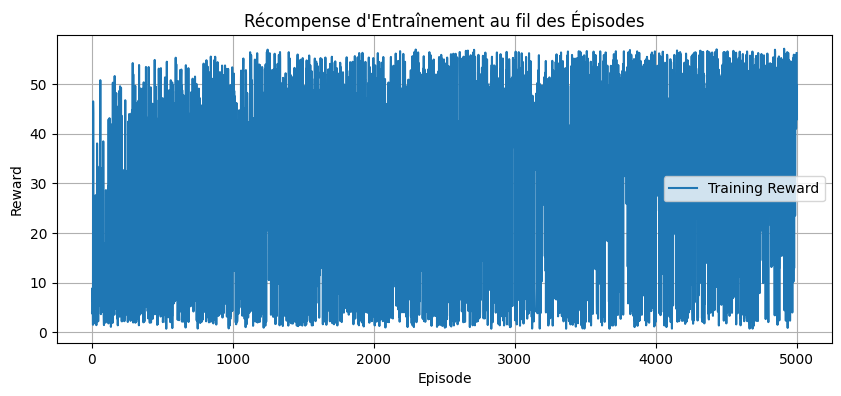

In [53]:
# Tracer la courbe de la récompense pendant l'entraînement
plt.figure(figsize=(10, 4))
plt.plot(train_data['Episode'], train_data['Reward'], label='Training Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Récompense d\'Entraînement au fil des Épisodes')
plt.legend()
plt.grid(True)
plt.show()

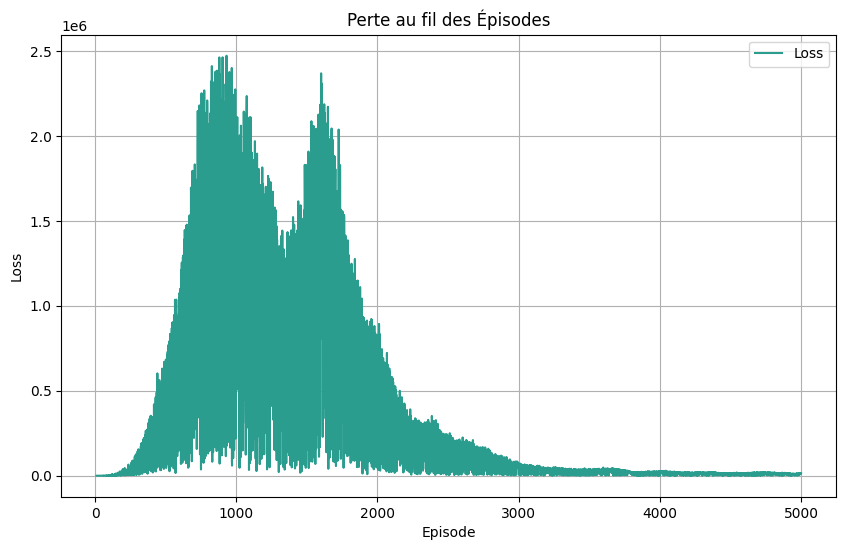

In [54]:
# Tracer la courbe de la perte pendant l'entraînement
plt.figure(figsize=(10, 6))
plt.plot(train_data['Episode'], train_data['Loss'], label='Loss', color='#2A9D8F')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Perte au fil des Épisodes')
plt.legend()
plt.grid(True)
plt.show()


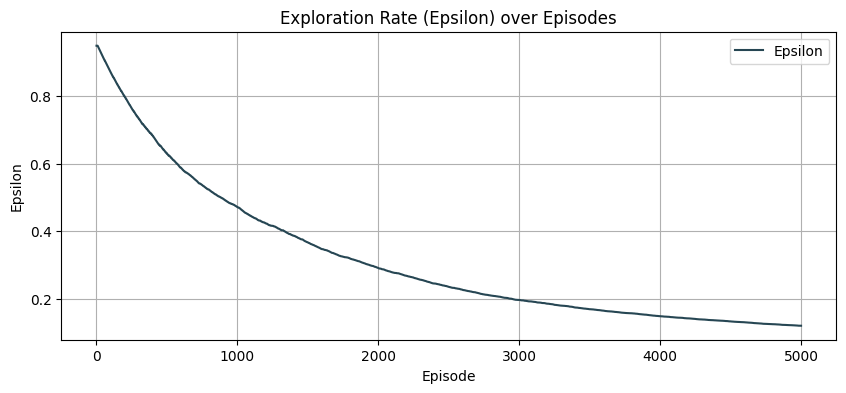

In [55]:

# Plot Epsilon Decay
plt.figure(figsize=(10, 4))
plt.plot(train_data["Episode"], train_data["Epsilon"], label="Epsilon", color="#264653")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Exploration Rate (Epsilon) over Episodes")
plt.grid(True)
plt.legend()
plt.show()


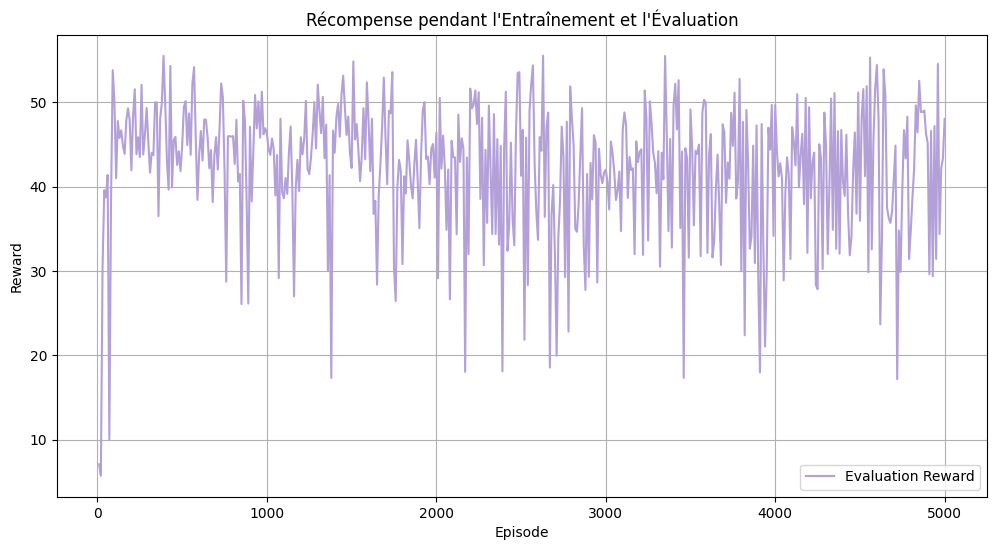

In [56]:
# Tracer la courbe de la récompense en évaluation
plt.figure(figsize=(12, 6))
plt.plot(eval_data['episode'], eval_data['mean_eval_reward'], label='Evaluation Reward', color='#B3A0D8')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Récompense pendant l\'Entraînement et l\'Évaluation')
plt.legend()
plt.grid(True)
plt.show()


********************

In [61]:
agent = DQN(
    environment=env,
    gamma=0.99,
    batch_size=128,
    buffer_capacity=10_000,
    update_target_every=32,
    epsilon_start=0.0,  
    decrease_epsilon_factor=1000,
    epsilon_min=0.0,
    learning_rate=1e-3,
    hidden_size=64, 
)

model_path = "dqn_evaluation_results/best_model.pt"
agent.q_net.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
agent.q_net.eval()  # Mode évaluation (désactive dropout, batchnorm, etc.)

state, _ = env.reset()
done = False
total_reward = 0

while not done:
    action = agent.get_action(state, epsilon=0.0)  # on force l’exploitation pure
    next_state, reward, terminated, truncated, _ = env.step(action)
    env.render() 
    total_reward += reward
    state = next_state
    done = terminated or truncated

print(f"Total reward: {total_reward:.2f}")

Total reward: 48.34


Total reward: 54.84


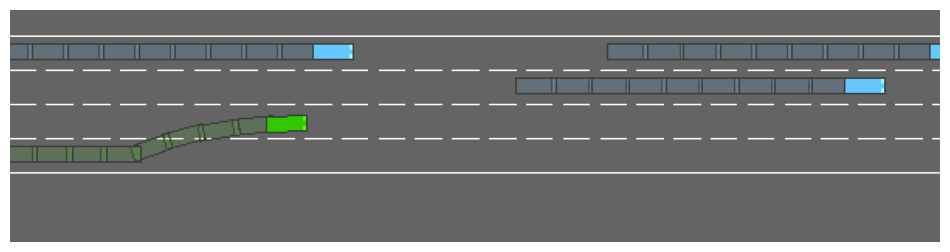

In [64]:
env = make_env()

agent = DQN(
    environment=env,
    gamma=0.99,
    batch_size=128,
    buffer_capacity=10_000,
    update_target_every=32,
    epsilon_start=0.0,  
    decrease_epsilon_factor=1000,
    epsilon_min=0.0,
    learning_rate=1e-3,
    hidden_size=64,  
)

agent.q_net.load_state_dict(torch.load("dqn_evaluation_results/best_model.pt"))
agent.q_net.eval()

frames = []
state, _ = env.reset()
done = False
total_reward = 0

while not done:
    frame = env.render()
    frames.append(frame)
    action = agent.get_action(state, epsilon=0.0)
    next_state, reward, terminated, truncated, _ = env.step(action)
    state = next_state
    total_reward += reward
    done = terminated or truncated

print(f"Total reward: {total_reward:.2f}")

def display_frames_as_gif(frames):
    fig = plt.figure(figsize=(12, 4))
    plt.axis("off")
    im = plt.imshow(frames[0])

    def update(i):
        im.set_array(frames[i])
        return [im]

    anim = animation.FuncAnimation(fig, update, frames=len(frames), interval=50)
    return HTML(anim.to_jshtml())

display_frames_as_gif(frames)


In [68]:
def evaluate_agent(agent, env, n_episodes=5, save_videos=False, video_dir="test_videos", fps=5):
    """
    Évalue un agent dans un environnement sur un nombre d'épisodes donné. Optionnellement, enregistre des vidéos de l'épisode.

    Paramètres :
    - agent : L'agent à évaluer.
    - env : L'environnement d'évaluation.
    - n_episodes (int) : Nombre d'épisodes à simuler (par défaut 5).
    - save_videos (bool) : Si True, enregistre les vidéos des épisodes (par défaut False).
    - video_dir (str) : Répertoire pour sauvegarder les vidéos (par défaut "test_videos").
    - fps (int) : Fréquence d'images des vidéos (par défaut 5).

    Retour :
    - list : Récompenses totales par épisode.
    """
    all_rewards = []

    for ep in range(n_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        frames = []

        while not done:
            if save_videos:
                frame = env.render()
                frames.append(frame)

            action = agent.get_action(state, epsilon=0.0)  
            next_state, reward, terminated, truncated, _ = env.step(action)
            state = next_state
            total_reward += reward
            done = terminated or truncated

        all_rewards.append(total_reward)

        if save_videos:
            ep_dir = os.path.join(video_dir, f"episode_{ep+1}")
            os.makedirs(ep_dir, exist_ok=True)
            gif_path = os.path.join(ep_dir, "animation.gif")
            imageio.mimsave(gif_path, frames, fps=fps)
            print(f"Saved episode {ep+1} to {gif_path}")

    mean_reward = np.mean(all_rewards)
    std_reward = np.std(all_rewards)
    all_rewards = [round(float(reward), 2) for reward in all_rewards]

    print("\n### Résultats de l'évaluation ###")
    print(f"Nombre d'épisodes évalués : {n_episodes}")
    print("-" * 30)
    print(f"Récompense moyenne : {mean_reward:.2f}")
    print(f"Écart type des récompenses : {std_reward:.2f}")
    print("-" * 30)
    return all_rewards


In [69]:
env = make_env()  
agent = DQN(
    environment=env,
    gamma=0.99,
    batch_size=128,
    buffer_capacity=10_000,
    update_target_every=32,
    epsilon_start=0.0,
    decrease_epsilon_factor=1000,
    epsilon_min=0.0,
    learning_rate=1e-3,
    hidden_size=64,  
)
agent.q_net.load_state_dict(torch.load("dqn_evaluation_results/best_model.pt"))
agent.q_net.eval()

evaluate_agent(agent, env, n_episodes=10, save_videos=True)

Saved episode 1 to test_videos/episode_1/animation.gif
Saved episode 2 to test_videos/episode_2/animation.gif
Saved episode 3 to test_videos/episode_3/animation.gif
Saved episode 4 to test_videos/episode_4/animation.gif
Saved episode 5 to test_videos/episode_5/animation.gif
Saved episode 6 to test_videos/episode_6/animation.gif
Saved episode 7 to test_videos/episode_7/animation.gif
Saved episode 8 to test_videos/episode_8/animation.gif
Saved episode 9 to test_videos/episode_9/animation.gif
Saved episode 10 to test_videos/episode_10/animation.gif

### Résultats de l'évaluation ###
Nombre d'épisodes évalués : 10
------------------------------
Récompense moyenne : 47.11
Écart type des récompenses : 11.26
------------------------------


[56.38, 56.88, 56.21, 56.11, 21.85, 56.25, 48.91, 37.5, 43.5, 37.54]


### Résultats de l'évaluation ###
Nombre d'épisodes évalués : 100
------------------------------
Récompense moyenne : 47.71
Écart type des récompenses : 9.72
------------------------------


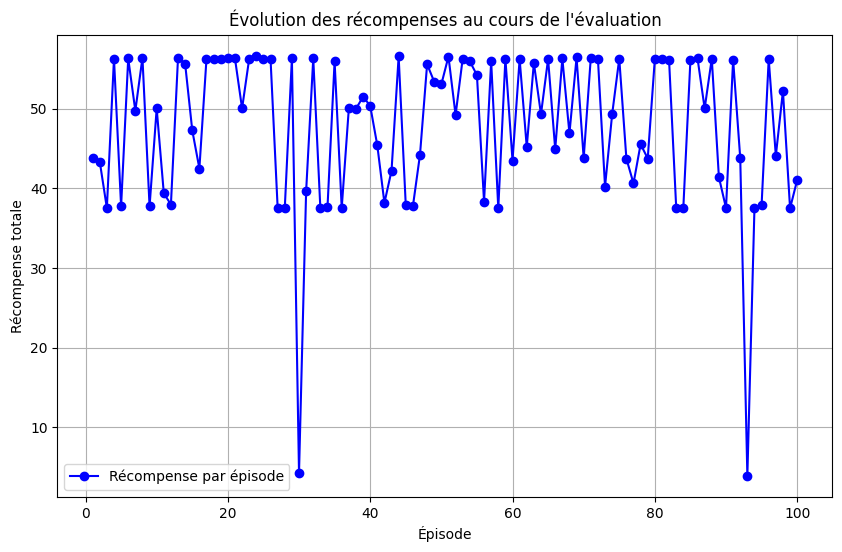

In [73]:
n_episodes=100
all_rewards=evaluate_agent(agent, env, n_episodes=100, save_videos=False)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_episodes+1), all_rewards, marker='o', color='b', label='Récompense par épisode')
plt.xlabel('Épisode')
plt.ylabel('Récompense totale')
plt.title('Évolution des récompenses au cours de l\'évaluation')
plt.grid(True)
plt.legend()
plt.show()